# Hyperparameter Tuning:

In [1]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.2 MB/s eta 0:00:00


In [ ]:
# ============================================================
# Hyperparameter Tuning
# Models : RandomForest, SVM
# Methods : GridSearchCV, RandomizedSearchCV, Optuna
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#import optuna
#from optuna.integration import SklearnPipelineSampler

import warnings
warnings.filterwarnings("ignore")

data = load_breast_cancer()
X = data.data
y = data.target


* 1. Baseline model

In [3]:
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

pipe_svm.fit(X_train, y_train)
pipe_svm.score(X_test, y_test)


0.9790209790209791

2. GridSearchCV sur SVM

In [4]:
grid_params = {
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", "auto"],
    "model__kernel": ["rbf", "linear"]
}

grid = GridSearchCV(pipe_svm, grid_params, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Test accuracy:", grid.score(X_test, y_test))


Best parameters: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Test accuracy: 0.986013986013986


3. RandomizedSearchCV

In [5]:
# rand_params = {
#     "model__C": np.logspace(-3, 3, 20),
#     "model__gamma": np.logspace(-4, 1, 20),
#     "model__kernel": ["rbf"]
# }

rand_params = {
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", "auto"],
    "model__kernel": ["rbf", "linear"]
}

rand = RandomizedSearchCV(
    pipe_svm, rand_params, n_iter=25, cv=5, n_jobs=-1, random_state=42)
rand.fit(X_train, y_train)

print("Best parameters:", rand.best_params_)
print("Test accuracy:", rand.score(X_test, y_test))

Best parameters: {'model__kernel': 'linear', 'model__gamma': 'scale', 'model__C': 0.1}
Test accuracy: 0.986013986013986


4. Tuning avec OPTUNA (optimisation bayésienne)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)


In [7]:
import optuna
#from optuna.integration import SklearnPipelineSampler
def objective(trial):
    C = trial.suggest_loguniform("model__C", 1e-3, 1e3)
    gamma = trial.suggest_loguniform("model__gamma", 1e-4, 1)
    kernel = trial.suggest_categorical("model__kernel", ["rbf", "linear"])

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(C=C, gamma=gamma, kernel=kernel))
    ])

    pipe.fit(X_train, y_train)
    return pipe.score(X_test, y_test)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

study.best_params


[I 2026-02-02 18:40:55,841] A new study created in memory with name: no-name-65da572b-7cef-49d8-b6dd-e3e521f555af
[I 2026-02-02 18:40:55,858] Trial 0 finished with value: 0.986013986013986 and parameters: {'model__C': 1.3809923116152933, 'model__gamma': 0.06438609540111725, 'model__kernel': 'rbf'}. Best is trial 0 with value: 0.986013986013986.
[I 2026-02-02 18:40:55,875] Trial 1 finished with value: 0.9440559440559441 and parameters: {'model__C': 0.15521883568993308, 'model__gamma': 0.022659731511675735, 'model__kernel': 'rbf'}. Best is trial 0 with value: 0.986013986013986.
[I 2026-02-02 18:40:55,887] Trial 2 finished with value: 0.986013986013986 and parameters: {'model__C': 0.14207057989389177, 'model__gamma': 0.0910622759534266, 'model__kernel': 'linear'}. Best is trial 0 with value: 0.986013986013986.
[I 2026-02-02 18:40:55,911] Trial 3 finished with value: 0.6293706293706294 and parameters: {'model__C': 0.005702427641955132, 'model__gamma': 0.41215012305742116, 'model__kernel': 

{'model__C': 1.3809923116152933,
 'model__gamma': 0.06438609540111725,
 'model__kernel': 'rbf'}

- On définit les hyperparams directement dans trial.suggest_*.

In [8]:
import optuna

def objective(trial):

    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1, log=True)
    kernel = trial.suggest_categorical("kernel", ["rbf", "linear"])

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(C=C, gamma=gamma, kernel=kernel))
    ])

    pipe.fit(X_train, y_train)
    return pipe.score(X_test, y_test)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

study.best_params


[I 2026-02-02 18:41:48,301] A new study created in memory with name: no-name-ea828bbb-cf5a-46da-a3ff-0aec5a9a3d72
[I 2026-02-02 18:41:48,341] Trial 0 finished with value: 0.6293706293706294 and parameters: {'C': 0.03632061831743992, 'gamma': 0.0012131574604366685, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6293706293706294.
[I 2026-02-02 18:41:48,356] Trial 1 finished with value: 0.965034965034965 and parameters: {'C': 5.401424123651992, 'gamma': 0.0031185019093691057, 'kernel': 'linear'}. Best is trial 1 with value: 0.965034965034965.
[I 2026-02-02 18:41:48,372] Trial 2 finished with value: 0.986013986013986 and parameters: {'C': 313.651002496742, 'gamma': 0.0005770138505985108, 'kernel': 'rbf'}. Best is trial 2 with value: 0.986013986013986.
[I 2026-02-02 18:41:48,387] Trial 3 finished with value: 0.9370629370629371 and parameters: {'C': 300.07075700805126, 'gamma': 0.02745835181909868, 'kernel': 'rbf'}. Best is trial 2 with value: 0.986013986013986.
[I 2026-02-02 18:41:48,400] 

{'C': 313.651002496742, 'gamma': 0.0005770138505985108, 'kernel': 'rbf'}

### Questions : go further

1️⃣ Tune a RandomForest : - n_estimators - max_depth - min_samples_split

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Best CV score: 0.9624076607387142


2️⃣ Compare the performances Grid vs Random vs Optuna.

Grid Search: only for small datasets or few hyperparameters.

Random Search: Good for quick experiments or large but not overly complex spaces.

Optuna: Best choice for practical, large-scale hyperparameter tuning, combining efficiency and accuracy.

In [10]:
print("Baseline SVM accuracy :", pipe_svm.score(X_test, y_test))
print("GridSearch SVM accuracy:", grid.score(X_test, y_test))
print("RandomSearch SVM accuracy:", rand.score(X_test, y_test))
print("Optuna SVM accuracy:", study.best_value)

Baseline SVM accuracy : 0.9790209790209791
GridSearch SVM accuracy: 0.986013986013986
RandomSearch SVM accuracy: 0.986013986013986
Optuna SVM accuracy: 0.986013986013986


3️⃣ Test Optuna with 200 trees.

In [13]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load Breast Cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Split dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define Optuna objective function for Random Forest
def objective(trial):
    n_estimators = 200  # Fixed number of trees
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Evaluate using 5-fold cross-validation
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust n_trials for more thorough search

# Print best hyperparameters and CV accuracy
print("Best parameters:", study.best_params)
print("Best CV accuracy:", study.best_value)

[I 2026-02-02 19:00:41,843] A new study created in memory with name: no-name-16a9af6d-0dc4-4238-ba76-a0eda15cf741
[I 2026-02-02 19:00:44,510] Trial 0 finished with value: 0.9560439560439562 and parameters: {'max_depth': 6, 'min_samples_split': 2}. Best is trial 0 with value: 0.9560439560439562.
[I 2026-02-02 19:00:47,163] Trial 1 finished with value: 0.9516483516483518 and parameters: {'max_depth': 16, 'min_samples_split': 9}. Best is trial 0 with value: 0.9560439560439562.
[I 2026-02-02 19:00:50,767] Trial 2 finished with value: 0.9516483516483518 and parameters: {'max_depth': 18, 'min_samples_split': 9}. Best is trial 0 with value: 0.9560439560439562.
[I 2026-02-02 19:00:53,545] Trial 3 finished with value: 0.9538461538461538 and parameters: {'max_depth': 18, 'min_samples_split': 5}. Best is trial 0 with value: 0.9560439560439562.
[I 2026-02-02 19:00:56,273] Trial 4 finished with value: 0.9604395604395606 and parameters: {'max_depth': 20, 'min_samples_split': 3}. Best is trial 4 with

Best parameters: {'max_depth': 20, 'min_samples_split': 3}
Best CV accuracy: 0.9604395604395606


4️⃣ Visualize the curve of convergence Optuna.

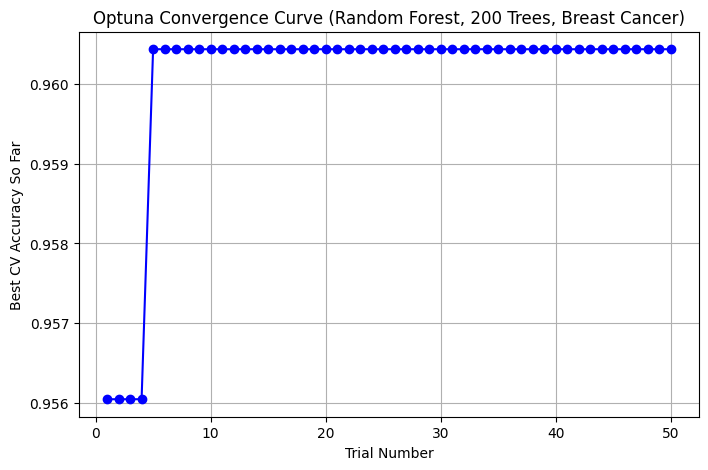

In [14]:
# Extract the trial values (CV accuracy for each trial)
best_values = [trial.value for trial in study.trials]

# Compute cumulative best (max so far) for a smoother convergence curve
cumulative_best = []
max_so_far = -float('inf')
for v in best_values:
    max_so_far = max(max_so_far, v)
    cumulative_best.append(max_so_far)

# Plot convergence
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_best)+1), cumulative_best, marker='o', linestyle='-', color='blue')
plt.xlabel("Trial Number")
plt.ylabel("Best CV Accuracy So Far")
plt.title("Optuna Convergence Curve (Random Forest, 200 Trees, Breast Cancer)")
plt.grid(True)
plt.show()
